In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 用途分解の計算

## 1. 概要

本ファイルは、用途分解の計算方法について記しています。  
ここで用途分解とは、家庭におけるエネルギー種別ごとの消費量つまり、消費電力、ガス消費量、灯油消費量から、家庭における用途別エネルギー消費量を推計する方法を言います。  
用途は、暖房・冷房・換気・給湯・照明・家電・調理に分類されます。
消費電力、ガス消費量、および灯油消費量は、領収書などから月単位で把握できているものとします。  
エネルギー種別の単位は以下のとおりです。  
- 消費電力  kwh
- ガス消費量  m<sup>3</sup>
- 灯油消費量  L

用途別エネルギーの推計は、エネルギー種別ごとに行います。  
電力を消費する用途としては、全ての用途が考えられます。  
ガスを消費する用途としては、暖房・給湯・調理が考えられます。  
灯油を消費する用途としては、暖房・給湯が考えられます。

用途が1つに限られている場合、例えば、灯油を暖房にしか使用していない場合などは、用途分解をするまでもなく用途が決定します。  
用途が複数にわたる場合、例えば、灯油を暖房と給湯に使用している場合などは、暖房は冬期にしか使用しないことから、灯油消費量の月別の推移を見ておおよそ暖房と給湯に分解します。  
電力の用途分解は非常に難しく、例えば電力を換気と照明に分類する場合、換気も照明も季節的な変動が見られないため、用途を分解するのは困難です。本方法では、一般的な家庭を想定した結果をデフォルト値として示しますので、家庭の事情（例えば日中照明を良く使っているなど）をヒアリングして、消費量を修正してください。

## 2. 基本的な関数

## 1) Bool値の配列(長さ=12)を受け取り該当する月を文字列で返す

In [2]:
def get_true_month(v):
    if len(v) != 12:
        raise ValueError('ERROR: Bool値の配列長が12ではありません。')
    months = ['Jan', 'Feb', 'Mar', 'Apl', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    str_months = [m for (i, m) in enumerate(months) if v[i]]
    return ', '.join(str_months)

In [3]:
get_true_month([True,True,True,True,True,True,True,True,True,True,True,True])

'Jan, Feb, Mar, Apl, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec'

### 2) 値から全体に対する割合を出す関数

In [4]:
def get_ratio(vs):
    total = sum(vs)
    return [0.0 if total == 0.0 else v/total for v in vs]

## 3. 中間月（暖房月・冷房月ではない月）の取得

### 概要

#### 1) 暖房月と冷房月の長さの確認

12の配列になっているのかを確認。

#### 2) 同じ月に暖房使用月と冷房使用月が同時に発生していないことの確認

同じ月に暖房使用月と冷房使用月が同時に発生した場合、用途分解が不可能なため、エラーとしてはじく。

#### 3) 中間期の取得

暖房月でも冷房月でもない月を中間月とする。

In [5]:
def get_intermediate_month(heating_use, cooling_use):
    
    if len(heating_use) != 12:
        raise ValueError('ERROR: 暖房の使用の有無が12ヶ月分ありません。')
    
    if len(cooling_use) != 12:
        raise ValueError('ERROR: 冷房の使用の有無が12ヶ月分ありません。')
    
    for h,c in zip(heating_use, cooling_use):
        if h and c:
            raise ValueError('エラー：同じ月に暖房使用月と冷房使用月は同時に設定できません。(' + str(i) + '月)' ) 
    
    intermdeate_month = [h == False and c == False for (h,c) in zip(heating_use, cooling_use)]

    return intermdeate_month

## 4. 暖冷房・給湯以外の用途のエネルギー消費量の推計（仮決め）

### 1) 換気

In [6]:
def get_std_consumption_for_ventilation(number_of_people, total_floor_area, ventilation_coeff):
    
    # general ventilation
    c = 33.9 # MJ/m2
    anual_general = c * total_floor_area # for general ventilation
    
    # local ventilation
    anual_local = {1 : 130.0, 2 : 259.0, 3 : 389.0, 4 : 518.0}[number_of_people]
    
    # divide to montly consumption
    month_ratios = [8.5, 7.7, 8.5, 8.2, 8.5, 8.2, 8.5, 8.5, 8.2, 8.5, 8.2, 8.5]
    return [month_ratio / 100 * (anual_general + anual_local) * ventilation_coeff for month_ratio in month_ratios]

#### Example

In [7]:
get_std_consumption_for_ventilation(4, 120.08, 1.0)

[390.04052,
 353.33082399999995,
 390.04052,
 376.27438399999994,
 390.04052,
 376.27438399999994,
 390.04052,
 390.04052,
 376.27438399999994,
 390.04052,
 376.27438399999994,
 390.04052]

### 2) 照明

In [8]:
def get_std_consumption_for_lighting(number_of_people,
                                     main_habitable_room_floor_area, other_habitable_room_floor_area, total_floor_area,
                                     lighting_coeff
                                    ):
    
    non_habitable_room_floor_area = total_floor_area - main_habitable_room_floor_area - other_habitable_room_floor_area
    
    a_MR, b_MR = {
        1: (28.4,  417.2),
        2: (58.0,  885.8),
        3: (65.7, 1002.3),
        4: (73.5, 1118.9)
    }[number_of_people]
    
    a_OR, b_OR = {
        1: ( 1.7,  38.5),
        2: ( 3.3,  78.0),
        3: (15.8, 432.1),
        4: (28.2, 786.2)
    }[number_of_people]

    a_NO, b_NO = {
        1: ( 3.2, 193.0),
        2: ( 7.8, 458.0),
        3: ( 9.7, 580.0),
        4: (11.6, 701.0)
    }[number_of_people]

    anual_MR = a_MR * main_habitable_room_floor_area + b_MR
    anual_OR = a_OR * other_habitable_room_floor_area + b_OR
    anual_NO = a_NO * non_habitable_room_floor_area + b_NO
    
    # divide to montly consumption
    month_ratios = [8.5, 7.7, 8.5, 8.2, 8.3, 8.2, 8.7, 8.5, 8.2, 8.4, 8.4, 8.4]
    
    return [month_ratio / 100 * (anual_MR + anual_OR + anual_NO) * lighting_coeff for month_ratio in month_ratios]

#### Example

In [9]:
get_std_consumption_for_lighting(4, 29.81, 54.34, 120.08, 1.0)

[573.436435,
 519.4659469999999,
 573.436435,
 553.1975019999999,
 559.943813,
 553.1975019999999,
 586.929057,
 573.436435,
 553.1975019999999,
 566.690124,
 566.690124,
 566.690124]

### 3) 家電

In [10]:
def get_std_consumption_for_electric_appliance(number_of_people, electric_appliance_coeff):
    
    anual = {1:9965.0, 2:12086.0, 3:16523.0, 4:17388}[number_of_people]
    
    month_ratios = [8.5, 7.7, 8.5, 8.2, 8.3, 8.2, 8.7, 8.5, 8.2, 8.4, 8.4, 8.4]
    
    return [month_ratio / 100 * anual * electric_appliance_coeff for month_ratio in month_ratios]

#### Example

In [11]:
get_std_consumption_for_electric_appliance(4, 1.0)

[1477.98,
 1338.876,
 1477.98,
 1425.8159999999998,
 1443.2040000000002,
 1425.8159999999998,
 1512.7559999999999,
 1477.98,
 1425.8159999999998,
 1460.592,
 1460.592,
 1460.592]

### 4) 調理

In [12]:
def get_std_consumption_for_cooking(number_of_people, cooking_coeff):
    
    anual = {1:2217.0, 2:2724.0, 3:3288.0, 4:3852}[number_of_people]
    
    month_ratios = [8.6, 7.8, 8.6, 8.1, 8.1, 8.4, 8.6, 8.6, 8.1, 8.4, 8.3, 8.4]
    
    return [month_ratio / 100 * anual * cooking_coeff for month_ratio in month_ratios]

#### Example

In [13]:
get_std_consumption_for_cooking(4, 1.0)

[331.272,
 300.456,
 331.272,
 312.012,
 312.012,
 323.56800000000004,
 331.272,
 331.272,
 312.012,
 323.56800000000004,
 319.716,
 323.56800000000004]

### 5) 暖冷房・給湯以外の消費量

In [14]:
def get_std_consumption(number_of_people,
                        main_habitable_room_floor_area, other_habitable_room_floor_area, total_floor_area,
                        ventilation_coeff, lighting_coeff, electric_appliance_coeff, cooking_coeff,
                        ventilation_use, lighting_use, electric_appliance_use, cooking_use
                       ):
    if ventilation_use:
        vent = get_std_consumption_for_ventilation(number_of_people, total_floor_area, ventilation_coeff)
    else:
        vent = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    if lighting_use:
        lighting = get_std_consumption_for_lighting(number_of_people,
                                                    main_habitable_room_floor_area, other_habitable_room_floor_area, total_floor_area,
                                                    lighting_coeff)
    else:
        lighting = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    if electric_appliance_use:
        ea = get_std_consumption_for_electric_appliance(number_of_people, electric_appliance_coeff)
    else:
        ea = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    if cooking_use:
        cooking = get_std_consumption_for_cooking(number_of_people, cooking_coeff)
    else:
        cooking = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
    total = [v+l+e+c for (v,l,e,c) in zip(vent, lighting, ea, cooking)]

    return vent, lighting, ea, cooking, total

#### Example

In [15]:
get_std_consumption(4, 29.81, 54.34, 120.08, 1.0, 1.0, 1.0, 1.0, True, True, True, True)

([390.04052,
  353.33082399999995,
  390.04052,
  376.27438399999994,
  390.04052,
  376.27438399999994,
  390.04052,
  390.04052,
  376.27438399999994,
  390.04052,
  376.27438399999994,
  390.04052],
 [573.436435,
  519.4659469999999,
  573.436435,
  553.1975019999999,
  559.943813,
  553.1975019999999,
  586.929057,
  573.436435,
  553.1975019999999,
  566.690124,
  566.690124,
  566.690124],
 [1477.98,
  1338.876,
  1477.98,
  1425.8159999999998,
  1443.2040000000002,
  1425.8159999999998,
  1512.7559999999999,
  1477.98,
  1425.8159999999998,
  1460.592,
  1460.592,
  1460.592],
 [331.272,
  300.456,
  331.272,
  312.012,
  312.012,
  323.56800000000004,
  331.272,
  331.272,
  312.012,
  323.56800000000004,
  319.716,
  323.56800000000004],
 [2772.728955,
  2512.1287709999997,
  2772.728955,
  2667.299886,
  2705.2003330000002,
  2678.855886,
  2820.9975769999996,
  2772.728955,
  2667.299886,
  2740.890644,
  2723.272508,
  2740.890644])

## 6. 暖冷房・給湯以外の用途が月別消費量を超えていないかどうかを確認し暖冷房・給湯の月別消費量を取得（給湯使用がある場合のみ）

In [16]:
def get_h_c_hws_value(total_std, consumption):

    def check(i, s, c):
        if s > c:
            raise ValueError('ERROR: 暖冷房・給湯以外の用途が月消費量を超えています。(' + str(i) + '月)' )
    
    # 暖冷房・給湯以外の用途が月別消費量を超えていないかどうかを確認
    [check(i,s,c) for (i, (s,c)) in enumerate(zip(total_std, consumption))]
    
    return [c-s for (s,c) in zip(total_std, consumption)]

## 7. 給湯消費量の月別割合（給湯使用がある場合のみ）

In [17]:
def get_hws_ratio():
    return [
        0.113029483482984,
        0.103264264682528,
        0.108322913038195,
        0.0884022587794812,
        0.0750187062626471,
        0.0653395455302283,
        0.0616377958319547,
        0.0519224042745101,
        0.0597337741598062,
        0.0772954737578718,
        0.0922799475117598,
        0.103753432688034
    ]

## 8. 暖冷房・給湯に使用していない月の消費割合と消費量から月消費量を求める

In [18]:
def get_monthly_value(ratio, middle_month, consumption):
    
    def mr(r, m):
        return r if m else 0.0
    
    middle_month_ratio = [mr(r,m) for (r,m) in zip(ratio, middle_month)]    
    middle_month_consumption = [mr(c,m) for (c,m) in zip(consumption, middle_month)]
    
    if True in middle_month:
        sum_ratio = sum(middle_month_ratio)
        sum_consumption = sum(middle_month_consumption)
    else:
        sum_ratio = min(ratio)
        sum_consumption = min(consumption)
    
    annual_consumption = 0.0 if sum_ratio == 0.0 else sum_consumption / sum_ratio
    
    def get_monthly(m,c,r,ac):
        if m:
            return c
        else:
            return min(c, ac*r)
    
    return [get_monthly(m,c,r,annual_consumption) for (m,c,r) in zip(middle_month, consumption, ratio)]

#### Example

In [19]:
get_monthly_value([0.085, 0.077, 0.085, 0.082, 0.083, 0.082, 0.087, 0.085, 0.082, 0.084, 0.084, 0.084],
                  [False, False, False, False, False, False, False, False, False, True, False, False],
                  [7519.0, 6810.0, 6588.0, 4422.0, 3791.0, 4032.0, 5420.0, 5458.0, 4212.0, 3774.0, 4661.0, 6705.0])

[3818.9285714285716,
 3459.5,
 3818.9285714285716,
 3684.1428571428573,
 3729.071428571429,
 3684.1428571428573,
 3908.7857142857138,
 3818.9285714285716,
 3684.1428571428573,
 3774.0,
 3774.0,
 3774.0]

## 9. 暖冷房消費量を求める（給湯使用がある場合のみ）

In [20]:
def get_h_w(heating_use, cooling_use, h_c_hws, hws):
    heating = [c-n if u else 0.0 for (c,n,u) in zip(h_c_hws, hws, heating_use)]
    cooling = [c-n if u else 0.0 for (c,n,u) in zip(h_c_hws, hws, cooling_use)]
    return heating, cooling

## 10. 全用途の消費量（給湯使用がない場合のみ）

In [21]:
def get_all_use(htg_use, ckg_use, consumption, v_l_e_c,
                vnt_prv, lgt_prv, eap_prv, ckg_prv, v_l_e_c_prv):
    
    htg = [c-n if u else 0.0 for (c,n,u) in zip(consumption, v_l_e_c, htg_use)]
    clg = [c-n if u else 0.0 for (c,n,u) in zip(consumption, v_l_e_c, ckg_use)]
    hws = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    vnt = [0.0 if s==0.0 else n*v/s for (n,v,s) in zip(v_l_e_c, vnt_prv, v_l_e_c_prv)]
    ltg = [0.0 if s==0.0 else n*l/s for (n,l,s) in zip(v_l_e_c, lgt_prv, v_l_e_c_prv)]
    eap = [0.0 if s==0.0 else n*e/s for (n,e,s) in zip(v_l_e_c, eap_prv, v_l_e_c_prv)]
    ckg = [0.0 if s==0.0 else n*c/s for (n,c,s) in zip(v_l_e_c, ckg_prv, v_l_e_c_prv)]
    
    return htg, clg, hws, vnt, ltg, eap, ckg

In [22]:
get_all_use([True, True, True, True, False, False, False, False, False, False, True, True],
            [False, False, False, False, True, True, True, True, True, False, False, False],
            [7519.0, 6810.0, 6588.0, 4422.0, 3791.0, 4032.0, 5420.0, 5458.0, 4212.0, 3774.0, 4661.0, 6705.0],
            [3817.0, 3459.0, 3817.0, 3672.0, 3724.0, 3688.0, 3884.0, 3817.0, 3672.0, 3774.0, 3749.0, 3774.0],
            [390.04052, 353.330824, 390.04052, 376.274384, 390.04052, 376.274384, 390.04052, 390.04052, 376.274384, 390.04052, 376.274384, 390.04052],
            [573.436435, 519.465947, 573.436435, 553.197502, 559.943813, 553.197502, 586.929057, 573.436435, 553.197502, 566.690124, 566.690124, 566.690124],
            [1477.98, 1338.876, 1477.98, 1425.816, 1443.204, 1425.816, 1512.756, 1477.98, 1425.816, 1460.592, 1460.592, 1460.592],
            [331.272, 300.456, 331.272, 312.012, 312.012, 323.568, 331.272, 331.272, 312.012, 323.568, 319.716, 323.568],
            [2772.728955, 2512.128771, 2772.728955, 2667.299886, 2705.200333, 2678.855886, 2820.997577, 2772.728955, 2667.299886, 2740.890644, 2723.272508, 2740.890644])

([3702.0, 3351.0, 2771.0, 750.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 912.0, 2931.0],
 [0.0, 0.0, 0.0, 0.0, 67.0, 344.0, 1536.0, 1641.0, 540.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [536.9384058096656,
  486.50822932515985,
  536.9384058096656,
  518.0068222924973,
  536.932839598316,
  518.0196275000364,
  537.0147752097839,
  536.9384058096656,
  518.0068222924973,
  537.0564220438121,
  517.9990843633927,
  537.0564220438121],
 [789.4052783082074,
  715.2629799139386,
  789.4052783082074,
  761.5721194328429,
  770.8230455892082,
  761.5909456116223,
  808.094440057011,
  789.4052783082074,
  761.5721194328429,
  780.2896232499234,
  780.135395424041,
  780.2896232499234],
 [2034.619954405172,
  1843.5249567865403,
  2034.619954405172,
  1962.8825313120417,
  1986.7259479595814,
  1962.9310540671615,
  2082.789560651934,
  2034.619954405172,
  1962.8825313120417,
  2011.1251866493658,
  2010.7276785243414,
  2011.1251866493658],
 [456.0363614769550

## 11. 全体計算

In [23]:
def kernel(number_of_people,
           main_habitable_room_floor_area, other_habitable_room_floor_area, total_floor_area,
           consumption,
           heating_use,
           cooling_use,
           ventilation_use, ventilation_coeff,
           hws_use, hws_coeff,
           lighting_use, lighting_coeff,
           ea_use, ea_coeff,
           cooking_use, cooking_coeff,
           comment
          ):
    
    intermdeate_month = get_intermediate_month(heating_use, cooling_use)
    if comment:
        print('中間月: ' + get_true_month(intermdeate_month))
    
    vnt_prv, lgt_prv, eap_prv, ckg_prv, v_l_e_c_prv \
        = get_std_consumption(number_of_people,
                              main_habitable_room_floor_area, other_habitable_room_floor_area, total_floor_area,
                              ventilation_coeff, lighting_coeff, ea_coeff, cooking_coeff,
                              ventilation_use, lighting_use, ea_use, cooking_use
                             )

    if comment:
        print('調整前の消費量')
        print('換気: ' + str(list(map(int,vnt_prv))))
        print('照明: ' + str(list(map(int,lgt_prv))))
        print('家電: ' + str(list(map(int,eap_prv))))
        print('調理: ' + str(list(map(int,ckg_prv))))
        print('全体: ' + str(list(map(int,v_l_e_c_prv))))

    if hws_use:
        
        if comment:
            print('給湯使用がある場合')

        h_c_hws = get_h_c_hws_value(v_l_e_c_prv, consumption)
        if comment:
            print('暖冷房給湯消費量: ' + str(list(map(int, h_c_hws))))
        
        hws = get_monthly_value(get_hws_ratio(), intermdeate_month, h_c_hws)
        if comment:
            print('給湯消費量: ' + str(list(map(int, hws))))
        
        htg, clg = get_h_w(heating_use, cooling_use, h_c_hws, hws)
        vnt, lgt, eap, ckg = vnt_prv, lgt_prv, eap_prv, ckg_prv

    else:
        
        if comment:
            print('給湯使用がない場合')
        
        v_l_e_c = get_monthly_value(get_ratio(v_l_e_c_prv), intermdeate_month, consumption)
        if comment:
            print('換気照明家電調理の消費量: ' + str(list(map(int, v_l_e_c))))
        
        htg, clg, hws, vnt, lgt, eap, ckg \
            = get_all_use(heating_use, cooling_use, consumption, v_l_e_c,
                          vnt_prv, lgt_prv, eap_prv, ckg_prv, v_l_e_c_prv)
        
    return htg, clg, hws, vnt, lgt, eap, ckg

## 12. 入力値のコンバート

In [24]:
def analysis(d, comment):
    return kernel(
        number_of_people = d['general']['number_of_people'],
        main_habitable_room_floor_area = d['general']['main_habitable_room_floor_area'],
        other_habitable_room_floor_area = d['general']['other_habitable_room_floor_area'],
        total_floor_area = d['general']['total_floor_area'],
        consumption = d['consumption'],
        heating_use = d['heating']['use'],
        cooling_use = d['cooling']['use'],
        ventilation_use = d['ventilation']['use'],
        ventilation_coeff = d['ventilation']['coeff'],
        hws_use = d['hot_water_supply']['use'],
        hws_coeff = d['hot_water_supply']['coeff'],
        lighting_use = d['lighting']['use'],
        lighting_coeff = d['lighting']['coeff'],
        ea_use = d['electric_appliance']['use'],
        ea_coeff = d['electric_appliance']['coeff'],
        cooking_use = d['cooking']['use'],
        cooking_coeff = d['cooking']['coeff'],
        comment = comment
    )

## 13. 結果の描画

### 1) グラフ

In [25]:
def plot_fig(htg, clg, hws, vnt, lgt, eap, ckg):
    
    y_htg = np.array(htg)
    y_clg = np.array(clg)
    y_hws = np.array(hws)
    y_vnt = np.array(vnt)
    y_lgt = np.array(lgt)
    y_eap = np.array(eap)
    y_ckg = np.array(ckg)
    
    figure, ax  = plt.subplots(1,1,figsize=(15,8))
    x = range(12)
    
    ax.bar(x, y_ckg, color='k', width=0.9, label='cooking')
    ax.bar(x, y_eap, color='g', width=0.9, label='electric appliances', bottom = y_ckg)
    ax.bar(x, y_lgt, color='y', width=0.9, label='lighting', bottom = y_ckg+y_eap)
    ax.bar(x, y_vnt, color='c', width=0.9, label='ventilation', bottom = y_ckg+y_eap+y_lgt)
    ax.bar(x, y_hws, color='m', width=0.9, label='how water supply', bottom = y_ckg+y_eap+y_lgt+y_vnt)
    ax.bar(x, y_clg, color='b', width=0.9, label='cooling', bottom = y_ckg+y_eap+y_lgt+y_vnt+y_hws)
    ax.bar(x, y_htg, color='r', width=0.9, label='heating', bottom = y_ckg+y_eap+y_lgt+y_vnt+y_hws+y_clg)
    
    ax.set_xticks(range(12))
    ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jly','Aug','Sep','Otc','Nov','Dec'])
    ax.legend()
    plt.show()

### 2) 表

In [26]:
def plot_table(htg, clg, hws, vnt, lgt, eap, ckg, consumption):
    df = pd.DataFrame({'暖房': list(map(int, htg)),
                       '冷房': list(map(int, clg)),
                       '給湯': list(map(int, hws)),
                       '換気': list(map(int, vnt)),
                       '照明': list(map(int, lgt)),
                       '家電': list(map(int, eap)),
                       '調理': list(map(int, ckg)),
                       '分解前': list(map(int, consumption))},
                       index=['Jan','Feb','Mar','Apr','May','Jun','Jly','Aug','Sep','Otc','Nov','Dec'])
    return df.T

## 14. 最終的な関数

In [27]:
def analysis_and_plot(d):
    htg, clg, hws, vnt, lgt, eap, ckg = analysis(d, False)
    plot_fig(htg, clg, hws, vnt, lgt, eap, ckg)
    print(plot_table(htg, clg, hws, vnt, lgt, eap, ckg, d['consumption']))

## 15. 使用例

### 15.1 入力データ

#### 1) 全体

辞書型データのKeyとして、  

- general
- consumption
- heating
- cooling
- ventilation
- hot_water_supply
- lighting
- electric_appliance
- cooking

を持ちます。

#### 2) general

'general'はさらに、

- number_of_people
- main_habitable_room_floor_area
- other_habitale_room_floor_area
- total_floor_area

を持ちます。

'number_of_people': 世帯の人数です。1～4人の数字を入力します。5人以上の計算には対応していないため、その場合は4人として推計してください。  
'main_habitable_room_floor_area': 主たる居室の床面積(m2)です。  
'othera_habitable_room_floor_area': その他の居室の床面積(m2)です。  
'total_floor_area': 述べ床面積(m2)です。  
主たる居室の床面積とその他の居室の床面積の合計が、述べ床面積を超えないようにしてください。

```
'general' : {
    'number_of_people' : 4,
    'main_habitable_room_floor_area' : 29.81,
    'other_habitable_room_floor_area' : 54.34,
    'total_floor_area' : 120.08,
}
```

#### 3) consumption

'consumption'は月ごとのエネルギー消費量であり、電力の場合はkWhまたはMJ、ガスの場合はm3またはMJ、灯油の場合はLまたはMJで入力します。月ごとの値はリストで指定します。リストの長さは必ず12でないといけません。

```
'consumption' : [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
```

#### 4) heating

'heating'はさらに、

- use

を持ちます。

'use'は暖房の使用月であり、長さ12のリストで指定します。暖房を使用している場合は、Trueを、使用していない場合は、Falseを指定します。

```
'heating' : {
    'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
}
```

#### 5) cooling

'cooling'はさらに、

- use

を持ちます。

'use'は暖房の使用月であり、長さ12のリストで指定します。暖房を使用している場合は、Trueを、使用していない場合は、Falseを指定します。

```
'cooling' : {
    'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
}
```

#### 6) ventilation / hot_water_supply / lighting / electric_appliance / cooking

'ventilation' 'ventilation' 'hot_water_supply' 'lighting' 'electric_appliance' 'cooking' それぞれ、はさらに、

- use
- coef

を持ちます。

'use'は、その用途にエネルギーが使われているかを指定します。True / False で指定します。Falsew を指定した場合は、'coef'の値は無視されます。  
'coef'は、調整係数を表します。調整係数とは、本計算方法によって計算された分解後の用途別給湯消費量を調整する役割を表しています。係数=1.0の場合は調整なしです。係数を1.0より大きくすると、該当する用途の消費量が増え、代わりにその他の用途の消費量が減ります。係数を1.0より小さくすると、該当する用途の消費量が減り、代わりにその他の用途の消費量が増えます。使用実態や居住者へのヒアリング結果などを踏まえて、係数の調整をしてください。係数の調整の仕方がわからない場合は、デフォルト値の1.0としておいてください。

```
'ventilation' : { 'use' : True, 'coeff' : 1.0 },
'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
'lighting' : { 'use' : True, 'coeff' : 1.0 },
'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
'cooking' : { 'use' : True, 'coeff' : 1.0 }
```

### 15.2 計算例

給湯を除く暖冷房・換気・照明・家電・調理に電力を使用する場合

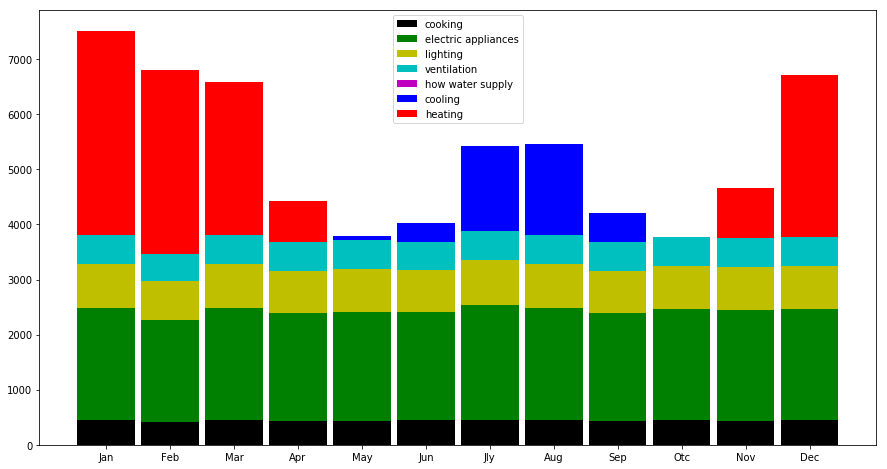

      Jan   Feb   Mar   Apr   May   Jun   Jly   Aug   Sep   Otc   Nov   Dec
暖房   3701  3350  2770   749     0     0     0     0     0     0   911  2931
冷房      0     0     0     0    66   343  1535  1640   539     0     0     0
給湯      0     0     0     0     0     0     0     0     0     0     0     0
換気    537   486   537   518   537   518   537   537   518   537   518   537
照明    789   715   789   761   771   761   808   789   761   780   780   780
家電   2035  1843  2035  1963  1987  1963  2082  2035  1963  2011  2011  2011
調理    456   413   456   429   429   445   456   456   429   445   440   445
分解前  7519  6810  6588  4422  3791  4032  5420  5458  4212  3774  4661  6705


In [28]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
    },
    'consumption' : [7519, 6810, 6588, 4422, 3791, 4032, 5420, 5458, 4212, 3774, 4661, 6705], 
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
    },
    'ventilation' : { 'use' : True, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
    'lighting' : { 'use' : True, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 }
})

全用途に電力を使用する場合

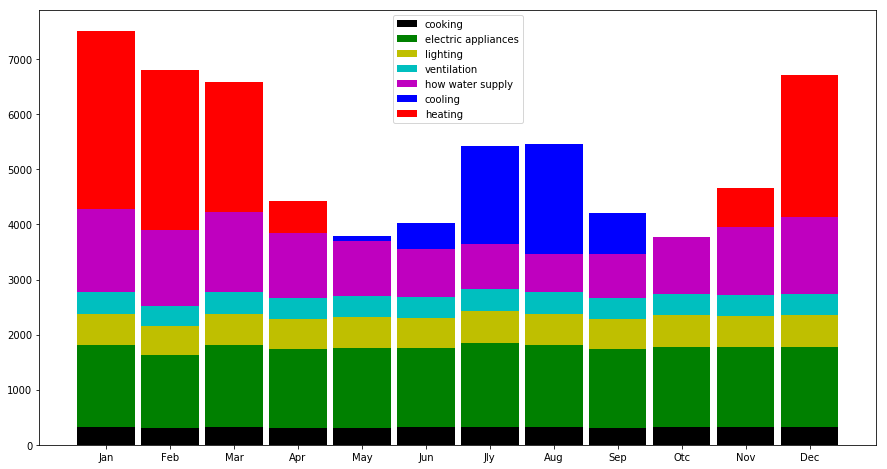

      Jan   Feb   Mar   Apr   May   Jun   Jly   Aug   Sep   Otc   Nov   Dec
暖房   3235  2917  2367   573     0     0     0     0     0     0   704  2577
冷房      0     0     0     0    83   479  1775  1991   746     0     0     0
給湯   1510  1380  1447  1181  1002   873   823   693   798  1033  1233  1386
換気    390   353   390   376   390   376   390   390   376   390   376   390
照明    573   519   573   553   559   553   586   573   553   566   566   566
家電   1477  1338  1477  1425  1443  1425  1512  1477  1425  1460  1460  1460
調理    331   300   331   312   312   323   331   331   312   323   319   323
分解前  7519  6810  6588  4422  3791  4032  5420  5458  4212  3774  4661  6705


In [29]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
    },
    'consumption' : [7519, 6810, 6588, 4422, 3791, 4032, 5420, 5458, 4212, 3774, 4661, 6705], 
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, True, True, True, True, True, False, False, False]
    },
    'ventilation' : { 'use' : True, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : True, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : True, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 }
})

暖房・給湯・調理にガスを使用する場合

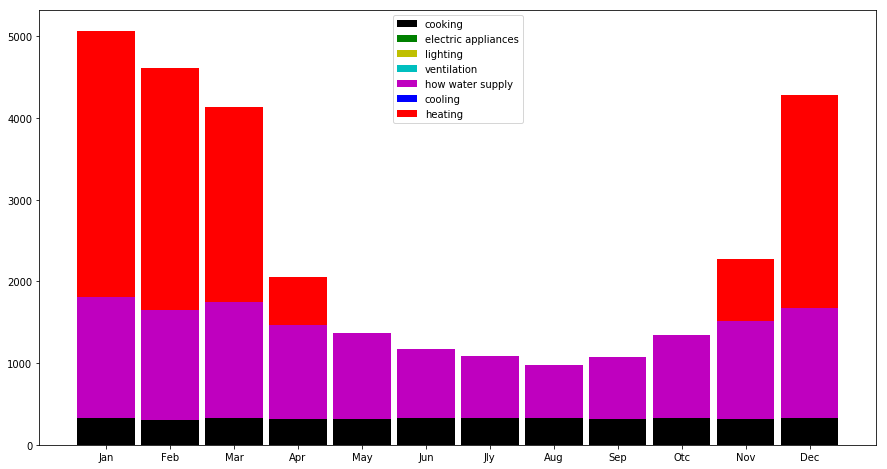

      Jan   Feb   Mar   Apr   May   Jun   Jly  Aug   Sep   Otc   Nov   Dec
暖房   3266  2961  2398   586     0     0     0    0     0     0   753  2602
冷房      0     0     0     0     0     0     0    0     0     0     0     0
給湯   1471  1344  1410  1151  1058   847   751  647   763  1021  1201  1351
換気      0     0     0     0     0     0     0    0     0     0     0     0
照明      0     0     0     0     0     0     0    0     0     0     0     0
家電      0     0     0     0     0     0     0    0     0     0     0     0
調理    331   300   331   312   312   323   331  331   312   323   319   323
分解前  5070  4607  4140  2050  1371  1171  1083  979  1076  1345  2275  4277


In [30]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
    },
    'consumption' : [5070, 4607, 4140, 2050, 1371, 1171, 1083, 979, 1076, 1345, 2275, 4277],
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 }
})

暖房・調理にガスを使用する場合

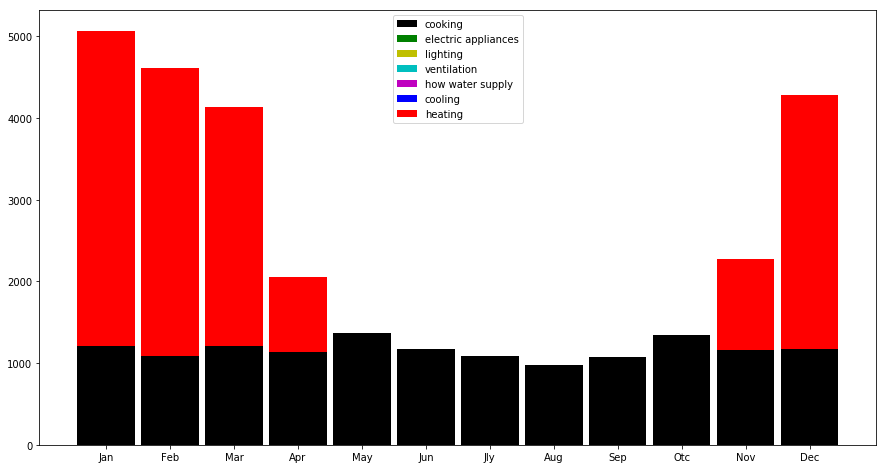

      Jan   Feb   Mar   Apr   May   Jun   Jly  Aug   Sep   Otc   Nov   Dec
暖房   3866  3515  2936   916     0     0     0    0     0     0  1113  3101
冷房      0     0     0     0     0     0     0    0     0     0     0     0
給湯      0     0     0     0     0     0     0    0     0     0     0     0
換気      0     0     0     0     0     0     0    0     0     0     0     0
照明      0     0     0     0     0     0     0    0     0     0     0     0
家電      0     0     0     0     0     0     0    0     0     0     0     0
調理   1203  1091  1203  1133  1371  1171  1083  979  1076  1345  1161  1175
分解前  5070  4607  4140  2050  1371  1171  1083  979  1076  1345  2275  4277


In [31]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
    },
    'consumption' : [5070, 4607, 4140, 2050, 1371, 1171, 1083, 979, 1076, 1345, 2275, 4277],
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : False, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : True, 'coeff' : 1.0 }
})

暖房・給湯に石油を使用する場合

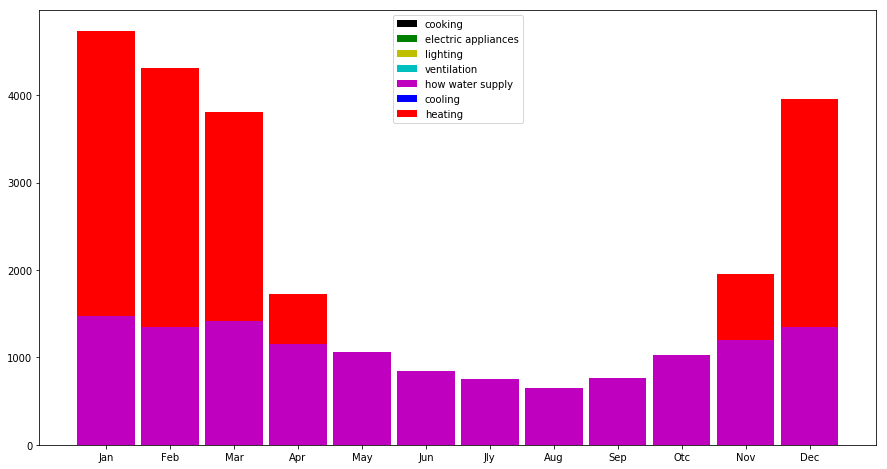

      Jan   Feb   Mar   Apr   May  Jun  Jly  Aug  Sep   Otc   Nov   Dec
暖房   3266  2963  2396   577     0    0    0    0    0     0   752  2603
冷房      0     0     0     0     0    0    0    0    0     0     0     0
給湯   1471  1344  1410  1151  1058  849  751  645  765  1023  1201  1351
換気      0     0     0     0     0    0    0    0    0     0     0     0
照明      0     0     0     0     0    0    0    0    0     0     0     0
家電      0     0     0     0     0    0    0    0    0     0     0     0
調理      0     0     0     0     0    0    0    0    0     0     0     0
分解前  4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955


In [32]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
    },
    'consumption' : [4738, 4308, 3807, 1729, 1058, 849, 751, 645, 765, 1023, 1954, 3955],
    'heating' : {
        'use' : [True, True, True, True, False, False, False, False, False, False, True, True]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : False, 'coeff' : 1.0 }
})

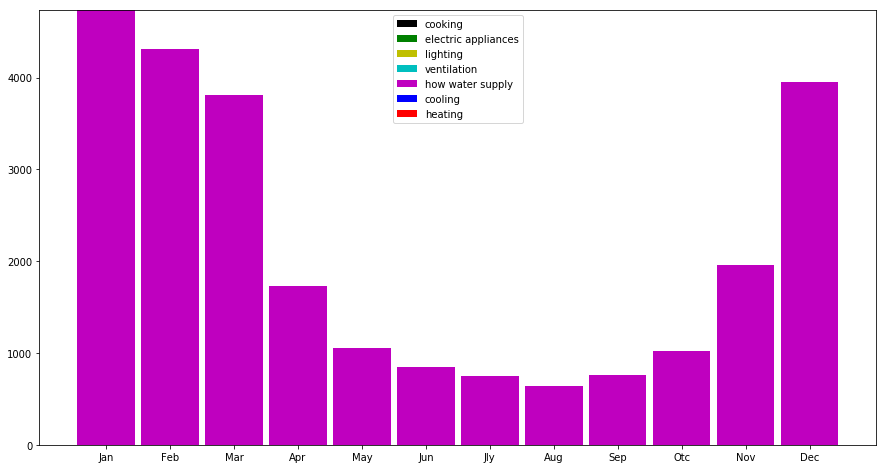

      Jan   Feb   Mar   Apr   May  Jun  Jly  Aug  Sep   Otc   Nov   Dec
暖房      0     0     0     0     0    0    0    0    0     0     0     0
冷房      0     0     0     0     0    0    0    0    0     0     0     0
給湯   4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955
換気      0     0     0     0     0    0    0    0    0     0     0     0
照明      0     0     0     0     0    0    0    0    0     0     0     0
家電      0     0     0     0     0    0    0    0    0     0     0     0
調理      0     0     0     0     0    0    0    0    0     0     0     0
分解前  4738  4308  3807  1729  1058  849  751  645  765  1023  1954  3955


In [33]:
analysis_and_plot({
    'general' : {
        'number_of_people' : 4,
        'main_habitable_room_floor_area' : 29.81,
        'other_habitable_room_floor_area' : 54.34,
        'total_floor_area' : 120.08,
    },
    'consumption' : [4738, 4308, 3807, 1729, 1058, 849, 751, 645, 765, 1023, 1954, 3955],
    'heating' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'cooling' : {
        'use' : [False, False, False, False, False, False, False, False, False, False, False, False]
    },
    'ventilation' : { 'use' : False, 'coeff' : 1.0 },
    'hot_water_supply' : { 'use' : True, 'coeff' : 1.0 },
    'lighting' : { 'use' : False, 'coeff' : 1.0 },
    'electric_appliance' : { 'use' : False, 'coeff' : 1.0 },
    'cooking' : { 'use' : False, 'coeff' : 1.0 }
})